In [1]:
from datasets.noised import DemosaicDataset

In [4]:
import torch
from torchvision import transforms

train_data_dir = "/home/safin/datasets/CASIA-WebFace/"
transform = transforms.Compose([
                         transforms.ToTensor()
                     ])
noised_dataset = DemosaicDataset(train_data_dir, transform=transform)
#     dataset_train = torchvision.datasets.ImageFolder(train_data_dir, transform=transform)
dataloader_train = torch.utils.data.dataloader.DataLoader(noised_dataset, shuffle=True, batch_size=8, pin_memory=True, num_workers=32)

In [10]:
import numpy as np
train_idx = np.load("/home/safin/datasets/CASIA-WebFace/casia_train_idxs.npy").tolist()
test_idx = np.load("/home/safin/datasets/CASIA-WebFace/casia_test_idxs.npy").tolist()

In [11]:
import random
random.shuffle(train_idx)
random.shuffle(test_idx)

# np.save("/home/safin/datasets/CASIA-WebFace/casia_train_idxs_shuffled.npy", np.asarray(train_idx))
# np.save("/home/safin/datasets/CASIA-WebFace/casia_test_idxs_shuffled.npy", np.asarray(test_idx))

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline


In [11]:
import numpy as np
import torch
import torch.nn.functional as F
import math, random
from PIL import Image


def bilinear(y):
    r""" Initialize with bilinear interpolation"""
    F_r = torch.FloatTensor([[1,2,1],[2,4,2],[1,2,1]])/4
    F_b = F_r
    F_g = torch.FloatTensor([[0,1,0],[1,4,1],[0,1,0]])/4
    bilinear_filter = torch.stack([F_r,F_g,F_b])[:,None]
    if y.is_cuda:
        bilinear_filter = bilinear_filter.cuda()
    res = F.conv2d(y, bilinear_filter,padding=1, groups=3)
    return res

def linrgb_to_srgb(img):
    """ Convert linRGB color space to sRGB 
        https://en.wikipedia.org/wiki/SRGB
    """
    assert img.dtype in [np.float32, np.float64] 
    img = img.copy()
    mask = img <= 0.0031308
    img[~mask] = (img[~mask]**(1/2.4))*(1.055) - 0.055
    img[mask] = img[mask] * 12.92
    return img

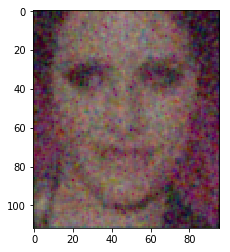

In [36]:
plt.imshow(linrgb_to_srgb(bilinear(noised_dataset[2][0].unsqueeze(0)).squeeze(0).permute(1,2,0).numpy()/255))

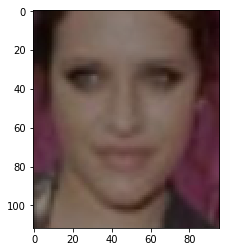

In [31]:
plt.imshow(noised_dataset[2][1].permute(1,2,0)/255)

In [29]:
(noised_dataset[2][1].permute(1,2,0)/255).max()

tensor(0.5647)

In [49]:
import torch as th

def log10(input):
    return input.log().div(th.Tensor([10]).type_as(input).log())

def psnr(input,other,peakVal = None, average = False, nargout = 1):
    
    assert(th.is_tensor(input) and th.is_tensor(other)),"The first two inputs "\
    +"must be tensors."
    
    if peakVal is None:
        peakVal = other.max()
    
    assert(input.shape == other.shape), "Dimensions mismatch between the two "\
    "input tensors."
    
    while input.dim() < 4:
        input = input.unsqueeze(0)
    while other.dim() < 4:
        other = other.unsqueeze(0)
    
    N = input.numel()
    batch = input.size(0)
    
    if N == 0:
        SNR = float('nan')
        MSE = 0
        return SNR, MSE
    
    MSE = (input-other).view(batch,-1).pow(2).mean(dim=1)
    
    #SNR = (10*th.log(peakVal**2/MSE)).div(math.log(10))
    SNR = 10*log10(peakVal**2/MSE)
    
    if average:
        return (SNR.mean(), MSE.mean()) if nargout == 2 else SNR.mean()
    else:
        return (SNR, MSE) if nargout == 2 else SNR

AVG PSNR = 21.2616


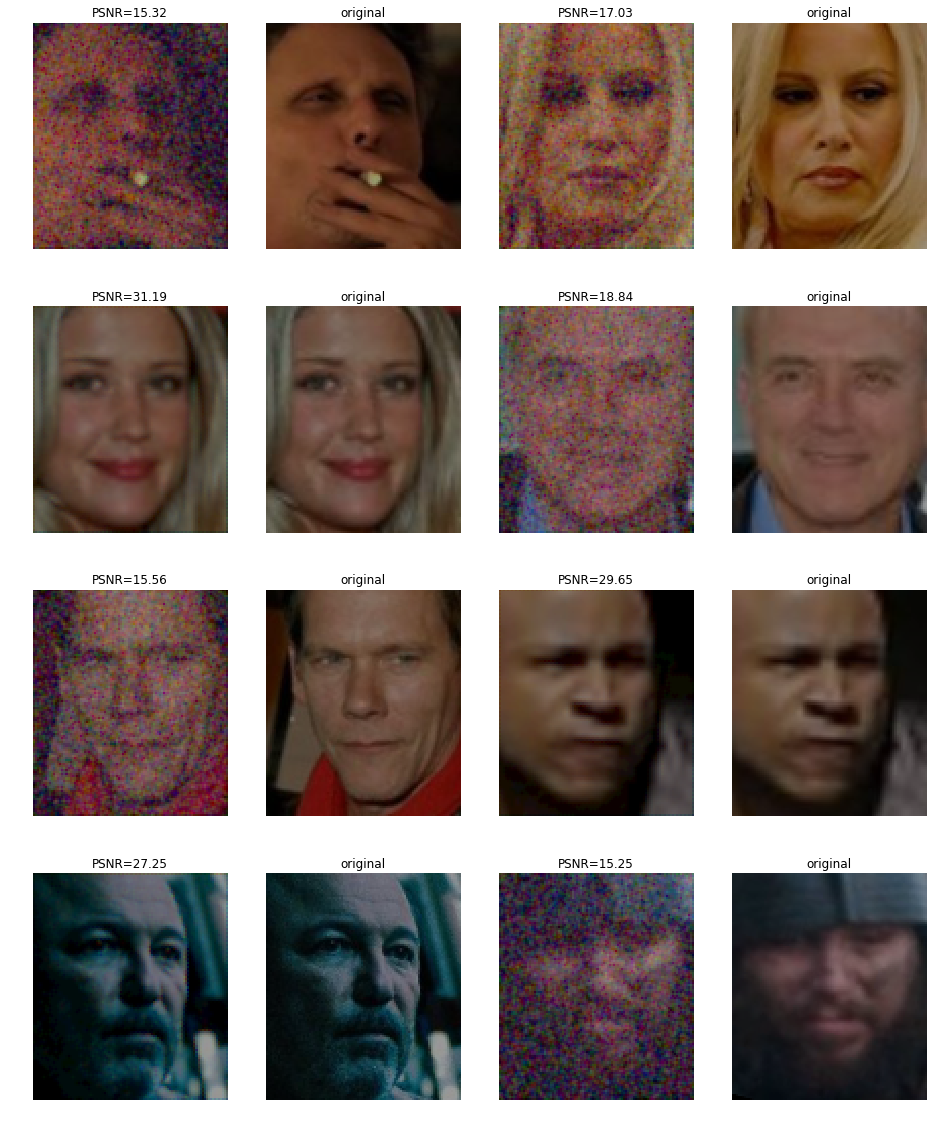

In [52]:
from loss import PSNR

fig_w = 16
fig_h = 20
fig=plt.figure(figsize=(fig_w, fig_h))
rows = 4
columns = 4

psnr_arr = []
for i in range(rows):
    for j in range(columns//2):
        img = noised_dataset[train_idx[i*rows+j]]
        noised = linrgb_to_srgb(bilinear(img[0].unsqueeze(0)).squeeze(0).permute(1,2,0).numpy()/255)
        gt = img[1].permute(1,2,0).numpy()/255

        fig.add_subplot(rows, columns, 1+i*columns+j*2)
        plt.imshow(noised)
        plt.axis('off')
#         cur_psnr = PSNR(torch.from_numpy(noised).unsqueeze(0), torch.from_numpy(gt).unsqueeze(0), PIXEL_MAX=1.)
        cur_psnr = psnr(torch.from_numpy(noised).unsqueeze(0), torch.from_numpy(gt).unsqueeze(0))
        psnr_arr.append(cur_psnr)
        plt.title("PSNR=%.2f" % cur_psnr.item())

        fig.add_subplot(rows, columns, 1+i*columns+j*2+1)
        plt.imshow(gt)
        plt.axis('off')
        plt.title("original")

        j += 1
    i += 1
print("AVG PSNR = %.4f" % np.mean(psnr_arr))

AVG PSNR = 26.1862


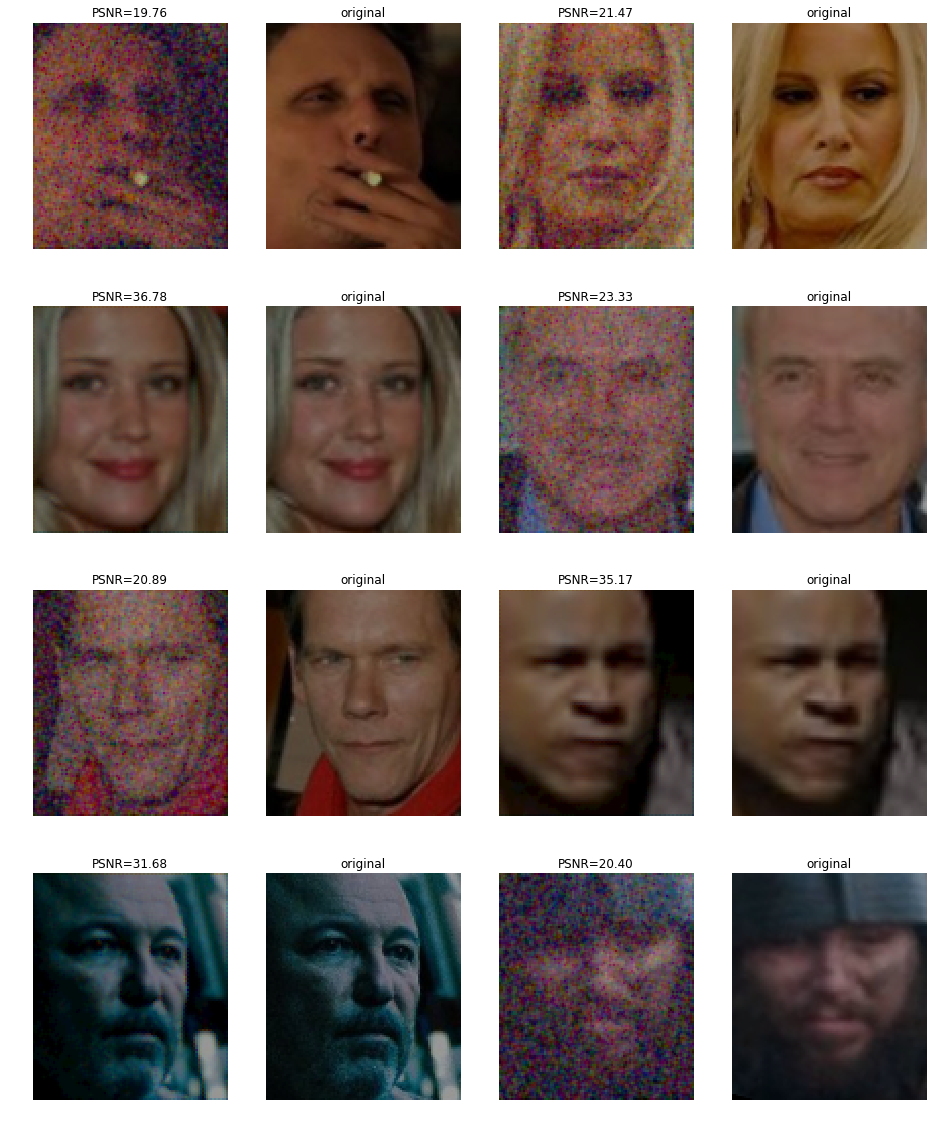

In [51]:
from loss import PSNR

fig_w = 16
fig_h = 20
fig=plt.figure(figsize=(fig_w, fig_h))
rows = 4
columns = 4

psnr_arr = []
for i in range(rows):
    for j in range(columns//2):
        img = noised_dataset[train_idx[i*rows+j]]
        noised = linrgb_to_srgb(bilinear(img[0].unsqueeze(0)).squeeze(0).permute(1,2,0).numpy()/255)
        gt = img[1].permute(1,2,0).numpy()/255

        fig.add_subplot(rows, columns, 1+i*columns+j*2)
        plt.imshow(noised)
        plt.axis('off')
        cur_psnr = PSNR(torch.from_numpy(noised).unsqueeze(0), torch.from_numpy(gt).unsqueeze(0), PIXEL_MAX=1.)
#         cur_psnr = psnr(torch.from_numpy(noised).unsqueeze(0), torch.from_numpy(gt).unsqueeze(0), 1.)
        psnr_arr.append(cur_psnr)
        plt.title("PSNR=%.2f" % cur_psnr.item())

        fig.add_subplot(rows, columns, 1+i*columns+j*2+1)
        plt.imshow(gt)
        plt.axis('off')
        plt.title("original")

        j += 1
    i += 1
print("AVG PSNR = %.4f" % np.mean(psnr_arr))

In [7]:
from transforms.noising import RawNoiseBayer
from datasets.lfw import LFWDataset

a = 0.15
b = 0.15
bayer_noised_transform = transforms.Compose([
#                          RawNoiseBayer(a, b, 0.7, 0.6),
                         transforms.ToTensor()
                     ])


transform = bayer_noised_transform #basic_transform #noise_transform
lfw_data_dir = "/home/safin/datasets/lfw/lfw-sphereface_noised_bayer/"
lfw_dataset = LFWDataset(lfw_data_dir, "/home/safin/datasets/lfw/pairs.txt", transform, "png")

In [15]:
import random
t = list(range(len(lfw_dataset)))
random.shuffle(t)

In [18]:
import numpy as np
np.save("/home/safin/datasets/lfw/noised_indx", np.asarray(t))

AVG PSNR = 16.8186


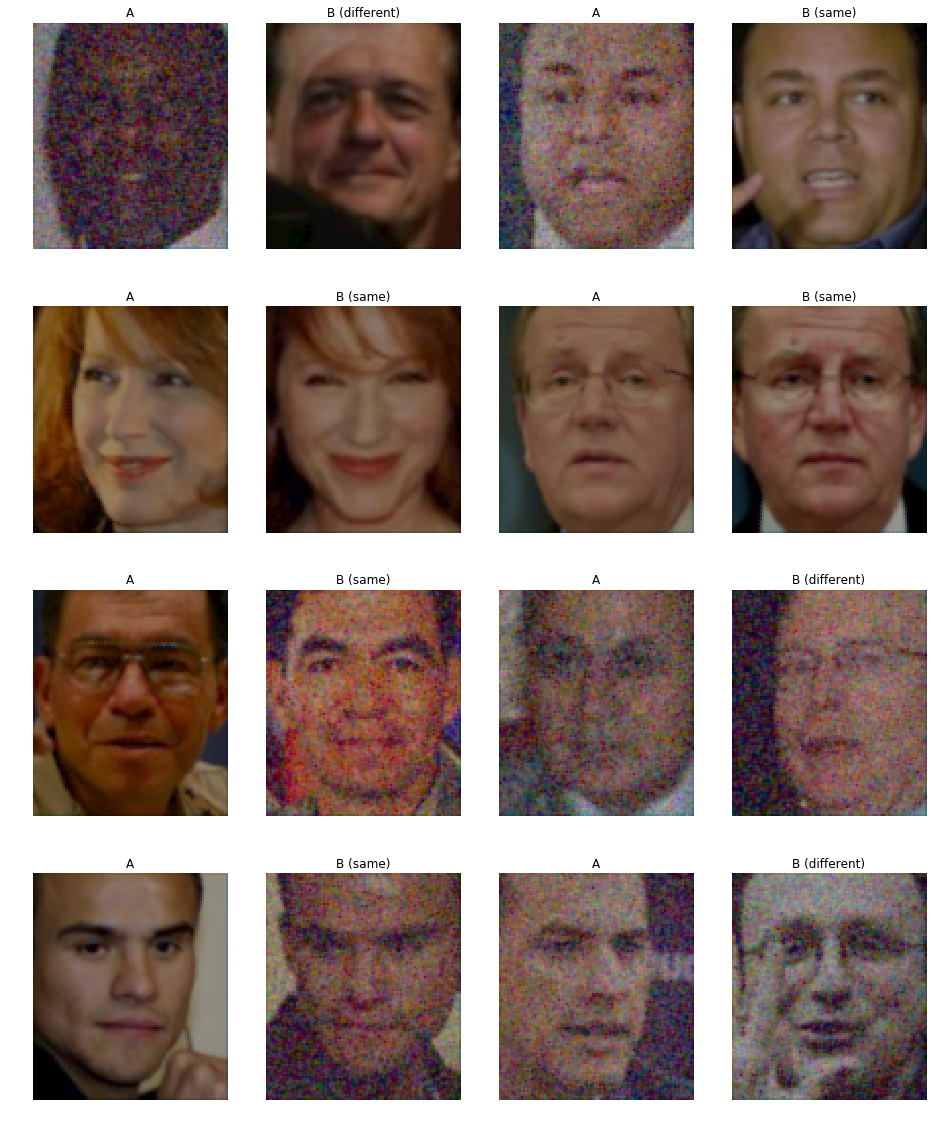

In [20]:
from loss import PSNR

fig_w = 16
fig_h = 20
fig=plt.figure(figsize=(fig_w, fig_h))
rows = 4
columns = 4

psnr_arr = []
for i in range(rows):
    for j in range(columns//2):
        img = lfw_dataset[t[i*rows+j]]
        noised = linrgb_to_srgb(bilinear(img[0].unsqueeze(0)).squeeze(0).permute(1,2,0).numpy())
        gt = linrgb_to_srgb(bilinear(img[1].unsqueeze(0)).squeeze(0).permute(1,2,0).numpy())

        fig.add_subplot(rows, columns, 1+i*columns+j*2)
        plt.imshow(noised)
        plt.axis('off')
        cur_psnr = PSNR(torch.from_numpy(noised).unsqueeze(0), torch.from_numpy(gt).unsqueeze(0), PIXEL_MAX=1.)
#         cur_psnr = psnr(torch.from_numpy(noised).unsqueeze(0), torch.from_numpy(gt).unsqueeze(0), 1.)
        psnr_arr.append(cur_psnr)
        plt.title("A")

        fig.add_subplot(rows, columns, 1+i*columns+j*2+1)
        plt.imshow(gt)
        plt.axis('off')
        res = "same" if img[2] else "different"
        plt.title("B (%s)" % res)

        j += 1
    i += 1
print("AVG PSNR = %.4f" % np.mean(psnr_arr))

In [1]:
import tqdm
import queue
import threading
from PIL import Image
import numpy as np
import os

num_worker_threads = 10

q_noised = queue.Queue()
threads_noised = []

def do_work(img, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    Image.fromarray(img.clip(0,255).astype(np.uint8)).save(path)

class ImageSaver(threading.Thread):
    def __init__(self, q, output_path):
        threading.Thread.__init__(self)
        self.q = q
        self.output_path = output_path
        
    def run(self):
        while True:
            item = self.q.get()
            if item is None:
                break
            img, path = item
            path = os.path.join(self.output_path, path)
            do_work(img, path)
            self.q.task_done()

In [2]:
lfw_data_dir = "/home/safin/datasets/lfw/lfw-sphereface/"
bayer_path = "/home/safin/datasets/lfw/lfw-sphereface_noised_bayer/"

for i in range(num_worker_threads):
    t = ImageSaver(q_noised, bayer_path)
    t.start()
    threads_noised.append(t)

In [3]:
from datasets.noised import NoisedBayerDataset
from transforms.noising import RawNoiseBayer
from torchvision import transforms

train_data_dir = "/tmp/CASIA-WebFace-sphereface/"
a = 0.15
b = 0.15

noised_dataset = NoisedBayerDataset(lfw_data_dir, transform=None, noise_transform=RawNoiseBayer(a, b, 0.7), scaler=0.6)


In [6]:
import time

t_start = time.time()

for sample in tqdm.tqdm_notebook(noised_dataset):
    noised, groundtruth, _ , path = sample
    noised = noised.permute(1,2,0).numpy()
    groundtruth = groundtruth.permute(1,2,0).numpy()
    q_noised.put_nowait((noised, path))


q_noised.join()
for i in range(num_worker_threads):
    q_noised.put(None)

for t in threads_noised:
    t.join()

t_end = time.time()
print(t_end-t_start)


46.12305521965027
